In [1]:
import torch
import numpy as np
import random
import os
from torch.utils.data import Dataset
from tqdm import tqdm
import librosa
from torch.utils.data import DataLoader
import librosa.display
from IPython.display import Audio
import random
import torch.nn as nn

In [2]:
CUTOFF = 64000
SPECT_CUTOFF = 501
EPS=1e-6
RANDOM_SIGNAL_LEVEL_DB = -40.0
SAMPLE_RATE = 16000

In [3]:
def preprocess_sound(audio):
    audio_stft = librosa.stft(audio, n_fft=512)
    amplitude, phase = np.abs(audio_stft), np.angle(audio_stft)
    return amplitude, phase

def convert_to_complex(amplitude, phase):
    return amplitude * np.vectorize(complex)(np.cos(phase), np.sin(phase))

def amp_to_decibel(S, ref = 1.0):
    #return 10 * np.log10( (S + EPS)  / ref)
    return 10 * np.log10( (S)  / ref)

def decibel_revert(db):
    return 10 ** (db / 10)

def signal_pad(signal, fixed_length = CUTOFF, noise_level = RANDOM_SIGNAL_LEVEL_DB):
    pad_length = fixed_length - signal.shape[0]
    pad = (np.random.rand(pad_length) - 0.5) * 2 * decibel_revert(noise_level)
    sound_extended = np.concatenate((signal, pad), axis=0)
    return sound_extended

def fit_sound(wav, cutoff = CUTOFF):
    if wav.shape[0] < cutoff:
        signal_padding = signal_pad(wav, fixed_length = cutoff)
        return signal_padding
    return wav[:cutoff]

def normalize(spect):
    spect_mean, spect_std = spect.mean(), spect.std()
    spect_normalized = (spect - spect_mean) / spect_std
    return spect_normalized, spect_mean, spect_std

def denormalize(spect, spect_mean, spect_std):
    return spect * spect_std + spect_mean

In [4]:
voice_path = os.path.join("..", "data", "voices_unzip", "speaker1", "arctic_a0003.wav")
src_speaker_path = os.path.join("..", "data", "voices_unzip", "speaker2")
target_speaker_path = os.path.join("..", "data", "voices_unzip", "speaker3")

In [5]:
sound, sr = librosa.load(voice_path, sr = SAMPLE_RATE)

In [6]:
print(len(sound))
Audio(sound, rate = SAMPLE_RATE)

80000


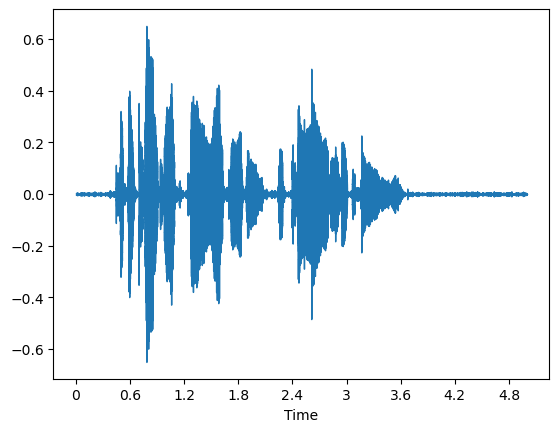

In [7]:
librosa.display.waveshow(sound, sr = SAMPLE_RATE)

64000


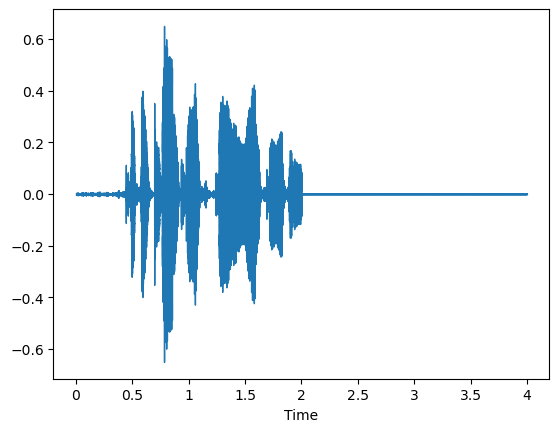

In [8]:
voice_1 = fit_sound(sound[:32000])
print(len(voice_1))
librosa.display.waveshow(voice_1, sr = SAMPLE_RATE)
Audio(voice_1, rate = SAMPLE_RATE)

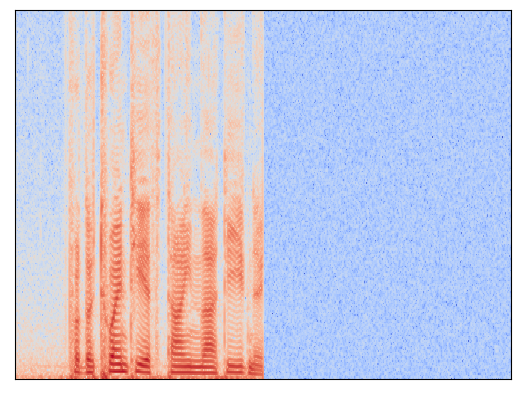

In [9]:
sound_amp, sound_phasis = preprocess_sound(voice_1)
sound_amp_decibel = amp_to_decibel(sound_amp)
sound_amp_decibel_rev = decibel_revert(sound_amp_decibel)
sound_again = convert_to_complex(sound_amp_decibel_rev, sound_phasis)
sound_again = librosa.istft(sound_again)
librosa.display.specshow(sound_amp_decibel)
Audio(sound_again, rate = SAMPLE_RATE)

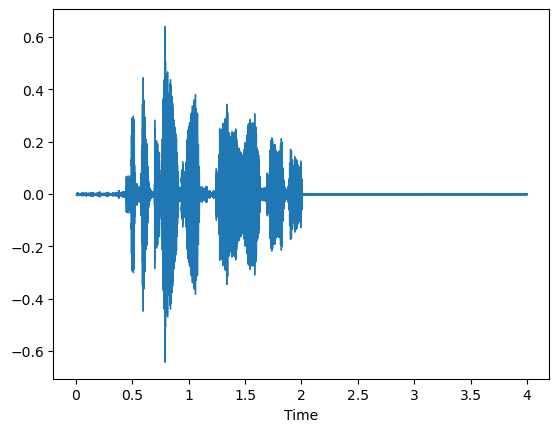

In [10]:
# Griffin-Lim reconstruction
reconstructed = librosa.griffinlim(sound_amp_decibel_rev)
librosa.display.waveshow(reconstructed, sr = SAMPLE_RATE)
Audio(reconstructed, rate = SAMPLE_RATE)

In [23]:
class Voice_Dataset(Dataset):
    def __init__(self, source_voice_path, target_voice_path):
        self.source_voice_path = source_voice_path
        self.target_voice_path = target_voice_path

        self.source_voices = os.listdir(self.source_voice_path)
        self.target_voices = os.listdir(self.target_voice_path)
        self.source_voices.sort()
        self.target_voices.sort()

        self.source_voices_len = len(self.source_voices)
        self.target_voices_len = len(self.target_voices)

        self.dataset_length = min(self.source_voices_len, self.target_voices_len)
        self.ids = [idx for idx in range(self.dataset_length)]
        random.shuffle(self.ids)

    def __len__(self):
        return self.dataset_length

    def __getitem__(self, index):
        sequence_idx = self.ids[index]
        src_voice = os.path.join(
                                self.source_voice_path,
                                self.source_voices[sequence_idx]
                                )
        target_voice = os.path.join(
                                  self.target_voice_path,
                                  self.target_voices[sequence_idx]
                                  )
        src_voice, _ = librosa.load(src_voice, sr = SAMPLE_RATE)
        target_voice, _ = librosa.load(target_voice, sr = SAMPLE_RATE)
        # set unified size of sound wave
        src_voice, target_voice = fit_sound(src_voice), fit_sound(target_voice)
        src_voice_amp, _ = preprocess_sound(src_voice)
        target_voice_amp, _ = preprocess_sound(target_voice)
        
        src_voice_amp = amp_to_decibel(src_voice_amp)
        target_voice_amp = amp_to_decibel(target_voice_amp)
        src_voice_amp = torch.from_numpy(src_voice_amp)
        target_voice_amp = torch.from_numpy(target_voice_amp)
        return src_voice_amp.unsqueeze(0).to(torch.float32), target_voice_amp.unsqueeze(0).to(torch.float32)

In [24]:
# test dataset
dataset = Voice_Dataset(src_speaker_path, target_speaker_path)
train_dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
train_iter = iter(train_dataloader)
training_batch = next(train_iter)
sp1, sp2 = training_batch
sp1, sp2 = sp1.squeeze(0), sp2.squeeze(0)
sp1, sp2 = sp1[0].numpy(), sp2[0].numpy()
print(sp1.shape)
print(sp2.shape)
voice_sp1 = librosa.griffinlim(decibel_revert(sp1))
voice_test1 = librosa.griffinlim(np.abs(decibel_revert(sp1)))
# voice_test2 = librosa.griffinlim(decibel_revert(np.abs(sp1)))# bad quality
voice_sp2 = librosa.griffinlim(decibel_revert(sp2))

(257, 501)
(257, 501)


In [25]:
Audio(voice_sp1, rate = SAMPLE_RATE)

In [26]:
Audio(voice_sp2, rate = SAMPLE_RATE)

In [61]:
# generator
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_act, **kwargs):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels,**kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(inplace = True) if use_act else nn.Identity()
        )
    def forward(self, x):
        return self.conv(x)

class ConvBlockUp(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super().__init__()
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(inplace = True)
        )
    def forward(self, x):
        return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, use_act = True, kernel_size = 3, padding=(1,1)),
            ConvBlock(channels, channels, use_act = False, kernel_size = 3, padding=(1,1))
        )
    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, channels, num_features = 64, num_residuals = 9):
        super().__init__()
        self.initial = nn.Sequential(
            ConvBlock(in_channels = channels, out_channels = num_features, use_act = True, kernel_size = 7, stride = 1, padding = (3,3), padding_mode = 'reflect')
        )
        self.down_blocks = nn.ModuleList(
            [
                ConvBlock(in_channels = num_features, out_channels = 2*num_features, use_act = True, kernel_size = 3, stride = 2, padding = (1,1), padding_mode = "reflect"),
                ConvBlock(in_channels = 2*num_features, out_channels = 4*num_features, use_act = True, kernel_size = 3, stride = 2, padding = (1,1), padding_mode = "reflect")
            ]
        )
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(channels = 4*num_features) for _ in range(num_residuals)]
        )
        self.up_blocks = nn.ModuleList(
            [
                ConvBlockUp(in_channels = 4*num_features, out_channels = 2*num_features, kernel_size = 3, stride = 2, padding = (1,1)),
                ConvBlockUp(in_channels = 2*num_features, out_channels = num_features, kernel_size = 3, stride = 2, padding = (1,1))
            ]
        )
        self.out_layer = nn.Conv2d(in_channels = num_features, out_channels = channels, kernel_size=7, stride=1, padding=(3,3), padding_mode="reflect")
  
    def forward(self, x):
        x = self.initial(x)
        for down_block in self.down_blocks:
            x = down_block(x)
        x = self.res_blocks(x)
        for up_block in self.up_blocks:
            x = up_block(x)
        return self.out_layer(x)

In [34]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, stride, 1, bias=True, padding_mode="reflect"),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class Discriminator(nn.Module):
    def __init__(self, in_channels=1, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(
                in_channels,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2, inplace=True),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(Block(in_channels, feature, stride=1 if feature==features[-1] else 2))
            in_channels = feature
        layers.append(nn.Conv2d(in_channels, 1, kernel_size=(4,4), stride=1, padding=1, padding_mode="reflect"))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial(x)
        return torch.sigmoid(self.model(x))

In [62]:
# test Generator
x = torch.randn((1, 1, 257, 501))
gen = Generator(1, 9)
#print(gen(x).shape)
x_gen = gen(x)
print(x_gen.shape)

torch.Size([1, 1, 257, 501])


In [37]:
# test Discriminator
discr = Discriminator(1)
x = torch.randn(1, 1, 257, 501)
print(x.shape)
x_discr = discr(x)
print(x_discr.shape)

torch.Size([1, 1, 257, 501])
torch.Size([1, 1, 30, 60])


In [47]:
class Config:
    def __init__(self):
        self.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
        self.BATCH_SIZE = 1
        self.LEARNING_RATE = 1e-5
        self.LAMBDA_IDENTITY = 10.0
        self.LAMBDA_CYCLE = 10
        self.NUM_WORKERS = 0
        self.NUM_EPOCHS = 1000
        self.CURRENT_EPOCH = 0
        self.LOAD_MODEL = False
        self.CHECKPOINT_GEN_TARGET = None
        self.CHECKPOINT_GEN_SRC = None
        self.CHECKPOINT_DISC_TARGET = None
        self.CHECKPOINT_TRG_SRC = None
        #
        self.SRC_VOICE_PATH = os.path.join("..", "data", "voices_unzip", "speaker2")
        self.TARGET_VOICE_PATH = os.path.join("..", "data", "voices_unzip", "speaker3")
        self.MODELS_PATH = ""

config = Config()

In [64]:
def train_fn(disc_target, disc_source, gen_source_target, gen_target_source, loader, opt_disc, opt_gen, l1, mse, d_scaler, g_scaler):
    TARGET_REALS = 0
    TARGET_FAKES = 0
    loop = tqdm(loader, leave=True)

    for idx, (source_voice, target_voice) in enumerate(loop):
        source_voice = source_voice.to(config.DEVICE)
        target_voice = target_voice.to(config.DEVICE)

        # Train Discriminators
        with torch.cuda.amp.autocast():
            fake_target_voice = gen_source_target(source_voice)
            d_target_voice_real = disc_target(target_voice)
            d_target_voice_fake = disc_target(fake_target_voice.detach())

            TARGET_REALS += d_target_voice_real.mean().item()
            TARGET_FAKES += d_target_voice_fake.mean().item()

            d_target_real_loss = mse(d_target_voice_real, torch.ones_like(d_target_voice_real))
            d_target_fake_loss = mse(d_target_voice_fake, torch.zeros_like(d_target_voice_fake))
            d_target_loss = d_target_real_loss + d_target_fake_loss

            fake_source_voice = gen_target_source(target_voice)

            d_src_real = disc_source(source_voice)
            d_src_fake = disc_source(fake_source_voice.detach())

            d_source_real_loss = mse(d_src_real, torch.ones_like(d_src_real))
            d_source_fake_loss = mse(d_src_fake, torch.zeros_like(d_src_fake))
            d_source_loss = d_source_real_loss + d_source_fake_loss

            D_loss = (d_target_loss + d_source_loss)/2

        opt_disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()
        # Train Generators
        with torch.cuda.amp.autocast():
            # adversarial loss for both generators
            d_target_fake = disc_target(fake_target_voice)
            d_source_fake = disc_source(fake_source_voice)

            loss_g_target = mse(d_target_fake, torch.ones_like(d_target_fake))
            loss_g_source = mse(d_source_fake, torch.ones_like(d_source_fake))

            # cycle loss
            cycle_source = gen_target_source(fake_target_voice)
            cycle_target = gen_source_target(fake_source_voice)
            cycle_source_loss = l1(source_voice, cycle_source)
            cycle_target_loss = l1(target_voice, cycle_target)

            # identity loss (remove these for efficiency if you set lambda_identity=0)
            identity_source = gen_target_source(source_voice)
            identity_target = gen_source_target(target_voice)
            identity_source_loss = l1(source_voice, identity_source)
            identity_target_loss = l1(target_voice, identity_target)

            G_loss = (
                loss_g_target
                + loss_g_source
                + cycle_source_loss * config.LAMBDA_CYCLE
                + cycle_target_loss * config.LAMBDA_CYCLE
                + identity_source_loss * config.LAMBDA_IDENTITY
                + identity_target_loss * config.LAMBDA_IDENTITY
            )
        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()
        loop.set_postfix(H_real=TARGET_REALS/(idx+1), H_fake=TARGET_FAKES/(idx+1))

In [30]:
def save_checkpoint(model, optimizer, config, filename="my_checkpoint.pth"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "current_epoch": config.CURRENT_EPOCH
    }
    torch.save(checkpoint, filename)

def load_checkpoint(model, optimizer, config, filename="my_checkpoint.pth"):
    checkpoint = torch.load(filename, map_location=config.DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    config.CURRENT_EPOCH = checkpoint["current_epoch"]
    for param_group in optimizer.param_groups:
          param_group["lr"] = config.LEARNING_RATE

In [65]:
def main(config):
    disc_target = Discriminator(in_channels=1).to(config.DEVICE)
    disc_source = Discriminator(in_channels=1).to(config.DEVICE)
    gen_source_target = Generator(channels=1, num_residuals=9).to(config.DEVICE)
    gen_target_source = Generator(channels=1, num_residuals=9).to(config.DEVICE)

    opt_disc = torch.optim.Adam(
        list(disc_target.parameters()) + list(disc_source.parameters()),
        lr=config.LEARNING_RATE,
        betas=(0.5, 0.999),
    )

    opt_gen = torch.optim.Adam(
        list(gen_source_target.parameters()) + list(gen_target_source.parameters()),
        lr=config.LEARNING_RATE,
        betas=(0.5, 0.999),
    )

    if config.LOAD_MODEL:
        load_checkpoint(
            config.CHECKPOINT_GEN_TARGET, gen_source_target, opt_gen, config.LEARNING_RATE,
        )
        load_checkpoint(
            config.CHECKPOINT_GEN_SRC, gen_target_source, opt_gen, config.LEARNING_RATE,
        )
        load_checkpoint(
            config.CHECKPOINT_DISC_TARGET, disc_target, opt_disc, config.LEARNING_RATE,
        )
        load_checkpoint(
            config.CHECKPOINT_TRG_SRC, disc_source, opt_disc, config.LEARNING_RATE,
        )

    L1 = nn.L1Loss()
    mse = nn.MSELoss()

    dataset = Voice_Dataset(source_voice_path = config.SRC_VOICE_PATH,
                  target_voice_path = config.TARGET_VOICE_PATH)
    loader = DataLoader(
        dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=True,
        num_workers=config.NUM_WORKERS,
        pin_memory=True
    )
    g_scaler = torch.cuda.amp.GradScaler()
    d_scaler = torch.cuda.amp.GradScaler()

    for epoch in range(config.NUM_EPOCHS):
        train_fn(disc_target, disc_source, gen_source_target, gen_target_source, loader, opt_disc, opt_gen, L1, mse, d_scaler, g_scaler)
        if epoch % 10 == 0 and epoch != 0:
            save_checkpoint(disc_target, opt_disc, filename=os.path.join(config.MODELS_PATH, f'disc_target{epoch}.pth'))
            save_checkpoint(disc_source, opt_disc, filename=os.path.join(config.MODELS_PATH, f'disc_source{epoch}.pth'))
            save_checkpoint(gen_target_source, opt_gen, filename=os.path.join(config.MODELS_PATH, f'disc_gen_source{epoch}.pth'))
            save_checkpoint(gen_source_target, opt_gen, filename=os.path.join(config.MODELS_PATH, f'disc_gen_source{epoch}.pth'))

In [66]:
main(config)

  6%|▌         | 67/1132 [00:30<08:03,  2.20it/s, H_fake=0.0363, H_real=0.958]


KeyboardInterrupt: 